In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import sklearn
from scipy.stats import chi2

In [2]:
sklearn.set_config(transform_output='pandas')

<h2>Task 2</h2>

In [2]:
df = pd.read_csv('/Users/herrakaava/Documents/school/statistical_methods_epidemiology/data/diet_data.csv', index_col=0)

In [3]:
df

,Age,Energy,logY,D
1,1,1,5.742683,2
2,2,1,6.777760,12
3,3,1,6.503539,14
4,1,0,6.410010,4
5,2,0,7.147638,5
6,3,0,6.789985,8


Let 
- $\, D_j(t) = \text{Number of events observed for group j at time t} \,$ 
- $\, Y_j(t) = \text{Exposure time (time at risk, person-time) for group j at time t} \,$ 
- $\, \lambda_j(t) = \text{hazard rate (events per unit time) for group j at time t} \,$ 


\begin{align*}
    \mathbb{E}[D_j(t)] &= \lambda_j(t) Y_j(t) \\
    \text{log}(\mathbb{E}[D_j(t)]) &= \text{log}(\lambda_j(t) Y_j(t)) \\
    \text{log}(\mathbb{E}[D_j(t)]) &= \text{log}(\lambda_j(t)) + \text{log}(Y_j(t)) \\
\end{align*}

Modelling assumption in [Poisson regression](https://en.wikipedia.org/wiki/Poisson_regression). Hence

\begin{equation*}
    \text{log}(\lambda_j(t)) = \beta_0 + \beta_1 \, \text{Energy}_i + \beta_2 \, \text{Age}_i
\end{equation*}

(i.e., the logarithmic rate is modelled as linear function of the covariates). And finally

\begin{align*}
    \text{log}(\mathbb{E}[D_j(t)]) &= \text{log}(\lambda_j(t)) + \text{log}(Y_j(t)) \\
    &= \beta_0 + \beta_1 \, \text{Energy}_i + \beta_2 \, \text{Age}_i + \text{log}(Y_j(t)).
\end{align*}

Rearranging the equation gives the hazard

\begin{align*}
    \text{log}(\mathbb{E}[D_j(t)]) &= \text{log}(\lambda_j(t)) + \text{log}(Y_j(t)) \\
    \text{log}(\mathbb{E}[D_j(t)]) - \text{log}(Y_j(t)) &= \text{log}(\lambda_j(t)) \\
    \text{log}(\lambda_j(t)) &= \text{log} \left(\frac{\mathbb{E}[D_j(t)]}{Y_j(t)} \right) \\
    \lambda_j(t) &= \frac{\mathbb{E}[D_j(t)]}{Y_j(t)}
\end{align*}

In [4]:
model = smf.glm(
    formula='D ~ C(Energy) + C(Age)',
    data=df,
    family=sm.families.Poisson(),
    offset=df['logY']
)
fit = model.fit()

In [5]:
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      D   No. Observations:                    6
Model:                            GLM   Df Residuals:                        2
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11.897
Date:                Sun, 06 Apr 2025   Deviance:                       1.6705
Time:                        16:10:11   Pearson chi2:                     1.65
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8834
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.4175      0.442    -12.

- Note that the coefficients are on log scale.
- To interpret them as multiplicative effects of the hazard rate, they need to be exponentiated.

In [31]:
# Point estimate for Hazard ratio (high. vs. low energy intake)
# and its 90% confidence interval

CI = np.exp(fit.conf_int(alpha=0.1).loc['C(Energy)[T.1]'])
pd.DataFrame({
    '5%': [np.round(CI[0], 3)],
    'Hazard ratio': [np.exp(fit.params['C(Energy)[T.1]']).round(3)],
    '95%': [np.round(CI[1], 3)]
})

,5%,Hazard ratio,95%
0,1.437,2.385,3.959


- `Energy` group 1 has $\, \approx 2.385 \,$ times higher hazard than the reference group (`Energy` group 0).

<h2>Task 3</h2>

In [3]:
plasma = pd.read_csv('/Users/herrakaava/Documents/school/statistical_methods_epidemiology/data/plasma.csv', index_col=0)

In [7]:
plasma.head()

,fibrinogen,globulin,ESR
1,2.52,38,ESR < 20
2,2.56,31,ESR < 20
3,2.19,33,ESR < 20
4,2.18,31,ESR < 20
5,3.41,37,ESR < 20


In [8]:
plasma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 1 to 29
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fibrinogen  32 non-null     float64
 1   globulin    32 non-null     int64  
 2   ESR         32 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ KB


In [9]:
plasma.isna().any()

fibrinogen    False
globulin      False
ESR           False
dtype: bool

In [10]:
plasma['ESR'].value_counts()

ESR
ESR < 20    26
ESR > 20     6
Name: count, dtype: int64

In [14]:
def convert_pandas_2_R(df):
    # Activate the automatic conversion of pandas DataFrames to R dataframes
    pandas2ri.activate()

    # Convert Python's DataFrame to R data.frame
    r_df = pandas2ri.py2rpy(df)

    # Assign the converted dataframe to the R environment
    ro.globalenv['r_df'] = r_df

In [15]:
convert_pandas_2_R(plasma)

In [17]:
%load_ext rpy2.ipython

In [22]:
%%R
r_df$ESR <- as.factor(r_df$ESR)

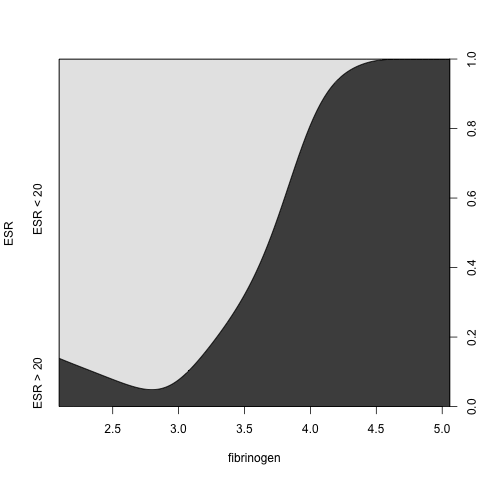

In [23]:
%%R
cdplot(ESR ~ fibrinogen, data = r_df)

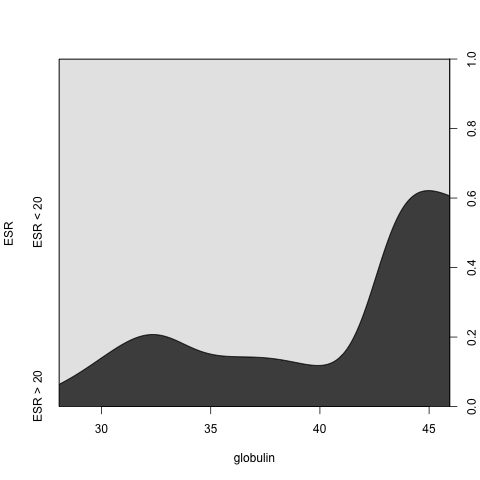

In [24]:
%%R
cdplot(ESR ~ globulin, data = r_df)

<h2>Task 4</h2>

In [4]:
def preprocess_label(data):
    pipe = make_pipeline(OrdinalEncoder(dtype=int))
    preprocess = ColumnTransformer([
        ('le', pipe, ['ESR'])
    ], remainder='passthrough', verbose_feature_names_out=False)
    transformed_data = preprocess.fit_transform(data)
    return transformed_data

In [5]:
plasma2 = preprocess_label(data=plasma)

- `ESR < 20` $\quad \rightarrow \quad$ 0
- `ESR > 20` $\quad \rightarrow \quad$ 1

In [6]:
def log_reg(data, formula):
    model = smf.logit(formula=formula, data=data)
    fit = model.fit()
    return model, fit

In [7]:
model1, fit1 = log_reg(data=plasma2, formula='ESR ~ fibrinogen')

Optimization terminated successfully.
         Current function value: 0.388131
         Iterations 6


In [8]:
print(fit1.summary())

                           Logit Regression Results                           
Dep. Variable:                    ESR   No. Observations:                   32
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                  0.1957
Time:                        10:11:06   Log-Likelihood:                -12.420
converged:                       True   LL-Null:                       -15.442
Covariance Type:            nonrobust   LLR p-value:                   0.01395
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.8451      2.770     -2.471      0.013     -12.275      -1.415
fibrinogen     1.8271      0.901      2.028      0.043       0.061       3.593


In [9]:
np.exp(fit1.params['fibrinogen'])

6.215715448566732

- A one-unit increase in fibrinogen increases the odds of class `ESR > 20` by a factor of 6.22.

In [10]:
np.exp(pd.DataFrame(fit1.conf_int(alpha=0.1).loc['fibrinogen']).T.set_axis(['5%', '95%'], axis=1))

,5%,95%
fibrinogen,1.41242,27.353836


<h2>Task 5</h2>

In [11]:
model2, fit2 = log_reg(data=plasma2, formula='ESR ~ fibrinogen + globulin')

Optimization terminated successfully.
         Current function value: 0.358924
         Iterations 7


In [12]:
print(fit2.summary())

                           Logit Regression Results                           
Dep. Variable:                    ESR   No. Observations:                   32
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                  0.2562
Time:                        10:11:23   Log-Likelihood:                -11.486
converged:                       True   LL-Null:                       -15.442
Covariance Type:            nonrobust   LLR p-value:                   0.01912
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.7921      5.796     -2.207      0.027     -24.153      -1.431
fibrinogen     1.9104      0.971      1.967      0.049       0.007       3.813
globulin       0.1558      0.120      1.303      0.1

In [13]:
print(np.exp(fit2.params['fibrinogen']))
print(np.exp(fit2.params['globulin']))

6.75557916477474
1.1685669309492768


- A one-unit increase in fibrinogen increases the odds of class `ESR > 20` by a factor of 6.76, while `globulin` is held constant.
- A one-unit increase in globulin increases the odds of class `ESR > 20` by a factor of 1.17, while `fibrinogen` is held constant.

In [15]:
np.exp(fit2.conf_int(alpha=0.1).loc[['fibrinogen', 'globulin']].set_axis(['5%', '95%'], axis=1))

,5%,95%
fibrinogen,1.367821,33.365375
globulin,0.959978,1.422479


- Since the $\, 90\% \,$ CI of the OR for `globulin` includes 1, it is not statistically significant.

Likelihood ratio is a ratio of likelihoods

$$ \Lambda = \frac{L_{\text{reduced}}}{L_{\text{full}}}. $$

The test statistic is given by

\begin{equation*}
    D = -2 \, \text{log}(\Lambda) = -2 \, \text{log} \left(\frac{L_{\text{reduced}}}{L_{\text{full}}} \right) = -2 (l_{\text{reduced}} - l_{\text{full}}) = 2 (l_{\text{full}} - l_{\text{reduced}}),
\end{equation*}

where $\, l \,$ is the log-likelihood.

In [39]:
def LR_test(fit1, fit2):
    D = 2 * (fit2.llf - fit1.llf)
    df_diff = fit2.df_model - fit1.df_model
    p = chi2.sf(D, df_diff)
    return {
        'Deviance': np.round(D, 4),
        'Pr(>Chi)': np.round(p,4)
    }

In [40]:
LR_test(fit1, fit2)

{'Deviance': 1.8692, 'Pr(>Chi)': 0.1716}

- Since the p-value is by far greater than any conventionally used threshold for statistical significance, we can conclude that there is not enough evidence to suggest that `globulin` significantly improves the model's fit to the data.

<h2>Task 6</h2>

[Reference](https://www.teachepi.org/wp-content/uploads/OldTE/documents/courses/fundamentals/Pai_Lecture12_Case%20Control%20Studies.pdf)

<table style="width:100%">
    <tr>
        <td style="text-align:center"> <b>Sampling design</b> </td>
        <td style="text-align:center"> <b>Controls samples from</b> </td>
        <td style="text-align:center"> <b>Effect measure that is estimated</b> </td>
    </tr>
    <tr>
        <td style="text-align:center">Cumulative sampling (traditional case control study)</td>
        <td style="text-align:center">People disease-free throughout the study period ("survivors" at the end of the follow-up) </td>
        <td style="text-align:center">Odds ratio (OR), which may numerically equal CIR if rare disease assumption holds</td>
    </tr>
    <tr>
        <td style="text-align:center">Case-cohort sampling</td>
        <td style="text-align:center">The baseline cohort (regardless of future disease status)</td>
        <td style="text-align:center">Cumulative incidence ratio (CIR) (does not need rare disease assumption)</td>
    </tr> 
    <tr>
        <td style="text-align:center">Risk set sampling / incidence density sampling</td> 
        <td style="text-align:center">People currenctly at risk in the risk set at the time an incidence case occurs in the study base</td> 
        <td style="text-align:center">Incidence density ratio (IDR) (does not need rare disease assumption)</td>
</table>